### Installation & Import

In [ ]:
!pip install rdkit
!pip install xgboost
!pip install optuna

In [ ]:
import os
import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Lipinski
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from xgboost.callback import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score
import joblib

In [ ]:
# version check
import xgboost
import sklearn
import optuna

print("xgboost version:", xgboost.__version__)
print("scikit-learn version:", sklearn.__version__)
print("optuna version:", optuna.__version__)

xgboost version: 3.0.3
scikit-learn version: 1.7.1
optuna version: 4.4.0


In [4]:
CFG = {
    'NBITS': 2048,
    'SEED': 42
}

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(CFG['SEED'])

# SMILES 데이터를 분자 지문으로 변환
def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=CFG['NBITS'])
        return np.array(fp)
    else:
        return np.zeros((CFG['NBITS'],))

In [5]:
def IC50_to_pIC50(ic50_nM):
    ic50_nM = np.clip(ic50_nM, 1e-10, None)
    return 9 - np.log10(ic50_nM)

In [63]:
def pIC50_to_IC50(pIC50):
    return 10 ** (9 - pIC50)

### Data Loading

In [6]:
IC50_dataset = pd.read_csv("C:/Users/user/Desktop/dacon_drug_development/IC50_dataset.csv")

In [7]:
IC50_dataset['Fingerprint'] = IC50_dataset['smiles'].apply(smiles_to_fingerprint)

[08:07:52] DEPRECATION WARNING: please use MorganGenerator
[08:07:52] DEPRECATION WARNING: please use MorganGenerator
[08:07:52] DEPRECATION WARNING: please use MorganGenerator
[08:07:52] DEPRECATION WARNING: please use MorganGenerator
[08:07:52] DEPRECATION WARNING: please use MorganGenerator
[08:07:52] DEPRECATION WARNING: please use MorganGenerator
[08:07:52] DEPRECATION WARNING: please use MorganGenerator
[08:07:52] DEPRECATION WARNING: please use MorganGenerator
[08:07:52] DEPRECATION WARNING: please use MorganGenerator
[08:07:52] DEPRECATION WARNING: please use MorganGenerator
[08:07:52] DEPRECATION WARNING: please use MorganGenerator
[08:07:52] DEPRECATION WARNING: please use MorganGenerator
[08:07:52] DEPRECATION WARNING: please use MorganGenerator
[08:07:52] DEPRECATION WARNING: please use MorganGenerator
[08:07:52] DEPRECATION WARNING: please use MorganGenerator
[08:07:52] DEPRECATION WARNING: please use MorganGenerator
[08:07:52] DEPRECATION WARNING: please use MorganGenerat

In [6]:
print(type(IC50_dataset['Fingerprint'].iloc[0]))

<class 'numpy.ndarray'>


### Molecular Descriptor

In [8]:
def descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    f = {}
    # 1. 화학기 존재 여부
    # Tetrazole ring
    tetrazole_smarts = ['c1nn[n+](n1)[O-]', 'c1[nH]nnn1']
    f['has_tetrazole'] = any(mol.HasSubstructMatch(Chem.MolFromSmarts(s)) for s in tetrazole_smarts)
    # Triazole ring
    f['has_triazole'] = mol.HasSubstructMatch(Chem.MolFromSmarts('c1nnc(n1)'))
    # Sulfoxide group
    f['has_sulfoxide'] = mol.HasSubstructMatch(Chem.MolFromSmarts('S(=O)(C)'))
    # Amide carbonyl
    amide_smarts = ['C(=O)N', 'NC(=O)']
    f['has_amide'] = any(mol.HasSubstructMatch(Chem.MolFromSmarts(s)) for s in amide_smarts)
    # Sulfonamide group
    f['has_sulfonamide'] = mol.HasSubstructMatch(Chem.MolFromSmarts('S(=O)(=O)N'))
    
    # 2. 분자량
    mw = Descriptors.MolWt(mol)
    f['mw'] = mw
    f['mw_300_500'] = 300<=mw<=500
    
    # 3. logP
    logp = Descriptors.MolLogP(mol)
    f['logP'] = logp
    f['logP_2_4'] = 2<=logp<=4
    
    # 4. TPSA
    tpsa = Descriptors.TPSA(mol)
    f['TPSA'] = tpsa
    f['TPSA_60_120'] = 60<=tpsa<=120
    
    # 5. rotatable bonds (IC50 값 높임_bad)
    rot = Lipinski.NumRotatableBonds(mol)
    f['rotatable'] = rot
    f['rot_gt7'] = rot>7

    # 6. ring (+aromatic)
    # ring 2개 이상
    num_rings = mol.GetRingInfo().NumRings()
    f['num_rings'] = num_rings
    f['ring_count_ge_2'] = num_rings >= 2
    # aromatic ring 존재 여부
    ssr = Chem.GetSymmSSSR(mol)
    aromatic_ring = any(all(mol.GetAtomWithIdx(idx).GetIsAromatic() for idx in ring) for ring in ssr)
    f['has_aromatic_ring'] = aromatic_ring
    # Ring 2개 이상 + 그 중 적어도 하나 aromatic인가?
    f['ring_ge2_and_aromatic'] = f['ring_count_ge_2'] and f['has_aromatic_ring']

    return f

In [9]:
features_df = pd.DataFrame([descriptors(s) for s in IC50_dataset['smiles']])

In [41]:
final_dataset = pd.concat([IC50_dataset, features_df], axis=1)

### Train/Validation data split

In [ ]:
# XGBoost에 넣으려면, Fingerprint를 실제 숫자 벡터 컬럼으로 풀어줘야 함.
# 예를 들어, [0, 1, 0, 1] → fp_0=0, fp_1=1, fp_2=0, fp_3=1 이렇게 컬럼별 숫자로 변환.

# 1. Fingerprint 컬럼을 여러 개 숫자 컬럼으로 변환
fp_df = pd.DataFrame(final_dataset['Fingerprint'].tolist(), index=final_dataset.index)

# 2. 컬럼 이름 부여 (fp_0, fp_1, ...)
fp_df.columns = [f'fp_{i}' for i in range(fp_df.shape[1])]

# 3. 기존 데이터에서 Fingerprint 컬럼 제거 후 합치기
final_dataset = pd.concat(
    [final_dataset.drop(columns=['Fingerprint']), fp_df],
    axis=1
)

In [48]:
# Define X (features) and y (target)
X = final_dataset.drop(['smiles', 'IC50_nM', 'pIC50'], axis=1)
y = final_dataset['pIC50']

In [49]:
# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

### Building XGBRegressor model & Train/Validation

#### 하이퍼파라미터 수정X

Train RMSE: 1.1715
Validation RMSE: 1.6037


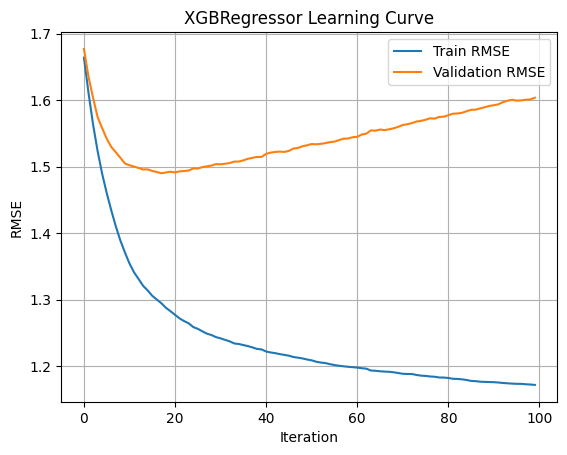

In [50]:
# Build and train the model
model = XGBRegressor(
    n_estimators=100, 
    random_state=42, 
    gamma=0,
    max_depth=6,
    reg_alpha=0,
    learning_rate=0.1,
    subsample=0.8,
    eval_metric='rmse'
    )
# model.fit(X_train, y_train)

# 모델 학습 (validation 데이터로 평가하며 학습 로그 저장)
eval_set = [(X_train, y_train), (X_val, y_val)]
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# 4. Train / Validation 예측 및 RMSE 계산
y_tr_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

rmse_train = mean_squared_error(y_train, y_tr_pred)**0.5
rmse_val = mean_squared_error(y_val, y_val_pred)**0.5

print(f"Train RMSE: {rmse_train:.4f}")
print(f"Validation RMSE: {rmse_val:.4f}")

# 학습 곡선 시각화 (학습 중 eval_metric 변화)
results = model.evals_result()
# print(results)
# {'validation_0': OrderedDict({'rmse': [1.6757005114492605, 1.6282027337926461, ... 1.204247449411131]}), 
#  'validation_1': OrderedDict({'rmse': [1.6871148585793638, 1.6656733565849058, ... 1.7407150872811847]})}
epochs = len(results['validation_0']['rmse'])
x_axis = range(epochs)

plt.plot(x_axis, results['validation_0']['rmse'], label='Train RMSE')
plt.plot(x_axis, results['validation_1']['rmse'], label='Validation RMSE')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('XGBRegressor Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

In [51]:
# Make predictions
predictions = model.predict(X_val)
print(predictions)

[ 7.630995   7.82085    7.506882   8.615394   7.7438354  7.8721137
  6.04543    6.873217   8.189926   6.873217   7.7907176  9.001693
  8.676523   7.836693   9.961205   7.515553   6.873217   8.236496
  7.8032436  6.924535   8.721891   6.7017403  6.873217   8.052856
  9.306874   8.124849   8.164332   6.5087996  6.873217   6.873217
  6.873217   7.8445826  9.10404    7.411709   7.184741   7.8777947
  9.306571   6.2808824  7.950636   8.234507   7.4467726  6.873217
 10.495907   8.727929   9.078336   7.817878   8.303316   9.758623
  8.197908   7.9128985  7.7443523  8.258657   5.749247   7.559815
  6.928156   7.317553   6.821294   7.7951813  9.217065   6.8171477
  7.755073   9.306874   6.109971   9.591785   7.2826123  7.724551
  8.615394   7.657      7.925459   7.938434   6.873217   8.6900425
  6.873217   8.164332   8.149224   7.2438927  7.6294117  8.958563
  7.8427386  7.6862116  9.3929205  7.521518   7.808702   8.822137
  7.655701   6.20937    7.8709755  8.236496   7.900044   6.873217
  7.41

In [52]:
# Evaluate the model
mse = mean_squared_error(y_val, predictions)
print(f"Model Mean Squared Error: {mse:.2f}")
# 0에 가까울수록 성능 좋음

Model Mean Squared Error: 2.57


In [53]:
# 성능평가
model.score(X_val, y_val)
# 1에 가까울수록 성능 좋음

0.1292767324754691

In [54]:
# 변수 중요도
for i, feature in enumerate(X.columns):
    print(f"{feature}: {model.feature_importances_[i]:.4f}")

has_tetrazole: 0.0000
has_triazole: 0.0007
has_sulfoxide: 0.0004
has_amide: 0.0004
has_sulfonamide: 0.0011
mw: 0.0008
mw_300_500: 0.0005
logP: 0.0006
logP_2_4: 0.0010
TPSA: 0.0009
TPSA_60_120: 0.0016
rotatable: 0.0014
rot_gt7: 0.0000
num_rings: 0.0012
ring_count_ge_2: 0.0000
has_aromatic_ring: 0.0000
ring_ge2_and_aromatic: 0.0000
fp_0: 0.0000
fp_1: 0.0012
fp_2: 0.0007
fp_3: 0.0000
fp_4: 0.0000
fp_5: 0.0007
fp_6: 0.0000
fp_7: 0.0000
fp_8: 0.0007
fp_9: 0.0009
fp_10: 0.0036
fp_11: 0.0007
fp_12: 0.0000
fp_13: 0.0000
fp_14: 0.0006
fp_15: 0.0000
fp_16: 0.0000
fp_17: 0.0000
fp_18: 0.0000
fp_19: 0.0000
fp_20: 0.0022
fp_21: 0.0000
fp_22: 0.0000
fp_23: 0.0000
fp_24: 0.0000
fp_25: 0.0000
fp_26: 0.0007
fp_27: 0.0000
fp_28: 0.0000
fp_29: 0.0004
fp_30: 0.0000
fp_31: 0.0000
fp_32: 0.0000
fp_33: 0.0001
fp_34: 0.0000
fp_35: 0.0000
fp_36: 0.0000
fp_37: 0.0000
fp_38: 0.0000
fp_39: 0.0000
fp_40: 0.0004
fp_41: 0.0000
fp_42: 0.0000
fp_43: 0.0004
fp_44: 0.0000
fp_45: 0.0007
fp_46: 0.0014
fp_47: 0.0000
fp_48:

#### Bayesian Optimization으로 하이퍼파라미터 튜닝

In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_categorical('n_estimators', [50, 100, 300, 500]),
        'max_depth': trial.suggest_categorical('max_depth', [3, 5, 7, 10]),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'subsample': trial.suggest_categorical('subsample', [0.5, 0.8, 1.0]),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.5, 0.8, 1.0]),
        'gamma': trial.suggest_categorical('gamma', [0, 1, 5]),
        'reg_alpha': trial.suggest_categorical('reg_alpha', [0, 0.01, 0.1]),
        'reg_lambda': trial.suggest_categorical('reg_lambda', [0, 1, 5, 10]),
        'random_state': 42,
        'early_stopping_rounds': 20,
        'eval_metric': 'rmse'
    }

    model = XGBRegressor(**params)
    model.fit(
        X_train, y_train, 
        eval_set=[(X_val, y_val)],
        verbose=False
        )

    preds = model.predict(X_val)
    rmse = mean_squared_error(y_val, preds) ** 0.5
    print(f"Trial RMSE: {rmse:.4f} | Params: {params}")
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)  # n_trials: 탐색 횟수

[I 2025-08-08 08:43:20,307] A new study created in memory with name: no-name-00493d1c-dac4-4d07-9739-31a57be5d79e
[I 2025-08-08 08:43:28,689] Trial 0 finished with value: 1.4576636990953784 and parameters: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.016211505122347626, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 0 with value: 1.4576636990953784.


Trial RMSE: 1.4577 | Params: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.016211505122347626, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:43:30,833] Trial 1 finished with value: 1.479741366622859 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.09359369704185914, 'subsample': 0.5, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 5}. Best is trial 0 with value: 1.4576636990953784.


Trial RMSE: 1.4797 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.09359369704185914, 'subsample': 0.5, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:43:41,613] Trial 2 finished with value: 1.4565592871206376 and parameters: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.010824734302882916, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5}. Best is trial 2 with value: 1.4565592871206376.


Trial RMSE: 1.4566 | Params: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.010824734302882916, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:43:43,613] Trial 3 finished with value: 1.5403043512790233 and parameters: {'n_estimators': 50, 'max_depth': 10, 'learning_rate': 0.09239319911366099, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 5}. Best is trial 2 with value: 1.4565592871206376.


Trial RMSE: 1.5403 | Params: {'n_estimators': 50, 'max_depth': 10, 'learning_rate': 0.09239319911366099, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:43:47,397] Trial 4 finished with value: 1.5042895910906262 and parameters: {'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.01908360937418457, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 1, 'reg_alpha': 0.1, 'reg_lambda': 1}. Best is trial 2 with value: 1.4565592871206376.


Trial RMSE: 1.5043 | Params: {'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.01908360937418457, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 1, 'reg_alpha': 0.1, 'reg_lambda': 1, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:43:49,375] Trial 5 finished with value: 1.477563890586819 and parameters: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.09967074197903024, 'subsample': 1.0, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0.01, 'reg_lambda': 5}. Best is trial 2 with value: 1.4565592871206376.


Trial RMSE: 1.4776 | Params: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.09967074197903024, 'subsample': 1.0, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0.01, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:43:51,691] Trial 6 finished with value: 1.5050195054634985 and parameters: {'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.07128698897842878, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 2 with value: 1.4565592871206376.


Trial RMSE: 1.5050 | Params: {'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.07128698897842878, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:43:54,206] Trial 7 finished with value: 1.492588333138879 and parameters: {'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.04308352427954002, 'subsample': 0.8, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}. Best is trial 2 with value: 1.4565592871206376.


Trial RMSE: 1.4926 | Params: {'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.04308352427954002, 'subsample': 0.8, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:43:56,737] Trial 8 finished with value: 1.4710268463348997 and parameters: {'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.03856903011277805, 'subsample': 0.8, 'colsample_bytree': 0.5, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 1}. Best is trial 2 with value: 1.4565592871206376.


Trial RMSE: 1.4710 | Params: {'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.03856903011277805, 'subsample': 0.8, 'colsample_bytree': 0.5, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 1, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:43:59,642] Trial 9 finished with value: 1.4713763662883177 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.03862949688492987, 'subsample': 0.8, 'colsample_bytree': 0.5, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 0}. Best is trial 2 with value: 1.4565592871206376.


Trial RMSE: 1.4714 | Params: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.03862949688492987, 'subsample': 0.8, 'colsample_bytree': 0.5, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 0, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:44:03,032] Trial 10 finished with value: 1.5369254194199702 and parameters: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.011051708164345813, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 1, 'reg_alpha': 0.01, 'reg_lambda': 0}. Best is trial 2 with value: 1.4565592871206376.


Trial RMSE: 1.5369 | Params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.011051708164345813, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 1, 'reg_alpha': 0.01, 'reg_lambda': 0, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:44:11,078] Trial 11 finished with value: 1.4718264986357819 and parameters: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.010312824250394325, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 10}. Best is trial 2 with value: 1.4565592871206376.


Trial RMSE: 1.4718 | Params: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.010312824250394325, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:44:19,595] Trial 12 finished with value: 1.4584211993756349 and parameters: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.017500385060558, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 10}. Best is trial 2 with value: 1.4565592871206376.


Trial RMSE: 1.4584 | Params: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.017500385060558, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:44:29,136] Trial 13 finished with value: 1.4590448997697196 and parameters: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01697307942073733, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 2 with value: 1.4565592871206376.


Trial RMSE: 1.4590 | Params: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01697307942073733, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:44:39,564] Trial 14 finished with value: 1.4561369382451375 and parameters: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.025411336206469487, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5}. Best is trial 14 with value: 1.4561369382451375.


Trial RMSE: 1.4561 | Params: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.025411336206469487, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:44:47,188] Trial 15 finished with value: 1.4680775542499878 and parameters: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.024035836090939917, 'subsample': 0.5, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5}. Best is trial 14 with value: 1.4561369382451375.


Trial RMSE: 1.4681 | Params: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.024035836090939917, 'subsample': 0.5, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:44:52,484] Trial 16 finished with value: 1.4602197436848174 and parameters: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.055389462526104015, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5}. Best is trial 14 with value: 1.4561369382451375.


Trial RMSE: 1.4602 | Params: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.055389462526104015, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:44:58,282] Trial 17 finished with value: 1.4648038980947262 and parameters: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.028884109747413903, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 1, 'reg_alpha': 0.01, 'reg_lambda': 5}. Best is trial 14 with value: 1.4561369382451375.


Trial RMSE: 1.4648 | Params: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.028884109747413903, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 1, 'reg_alpha': 0.01, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:45:06,605] Trial 18 finished with value: 1.4563073800026085 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.012899313154595582, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5}. Best is trial 14 with value: 1.4561369382451375.


Trial RMSE: 1.4563 | Params: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.012899313154595582, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:45:10,390] Trial 19 finished with value: 1.490276407001659 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.013432242407412651, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5}. Best is trial 14 with value: 1.4561369382451375.


Trial RMSE: 1.4903 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.013432242407412651, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:45:13,224] Trial 20 finished with value: 1.5049484253238468 and parameters: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.02306721030808473, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 1, 'reg_alpha': 0.01, 'reg_lambda': 0}. Best is trial 14 with value: 1.4561369382451375.


Trial RMSE: 1.5049 | Params: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.02306721030808473, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 1, 'reg_alpha': 0.01, 'reg_lambda': 0, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:45:20,743] Trial 21 finished with value: 1.4569863799042264 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.012679813627331785, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5}. Best is trial 14 with value: 1.4561369382451375.


Trial RMSE: 1.4570 | Params: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.012679813627331785, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:45:27,492] Trial 22 finished with value: 1.4769440097668027 and parameters: {'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.013567608974180911, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5}. Best is trial 14 with value: 1.4561369382451375.


Trial RMSE: 1.4769 | Params: {'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.013567608974180911, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:45:32,317] Trial 23 finished with value: 1.471114073583312 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.02425271943602954, 'subsample': 0.5, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5}. Best is trial 14 with value: 1.4561369382451375.


Trial RMSE: 1.4711 | Params: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.02425271943602954, 'subsample': 0.5, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:45:46,785] Trial 24 finished with value: 1.4558998899266515 and parameters: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.010588116021742285, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5}. Best is trial 24 with value: 1.4558998899266515.


Trial RMSE: 1.4559 | Params: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.010588116021742285, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:45:55,810] Trial 25 finished with value: 1.4597813947259066 and parameters: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.020434649001549923, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5}. Best is trial 24 with value: 1.4558998899266515.


Trial RMSE: 1.4598 | Params: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.020434649001549923, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:46:00,148] Trial 26 finished with value: 1.4616774698438932 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.030087533885899825, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5}. Best is trial 24 with value: 1.4558998899266515.


Trial RMSE: 1.4617 | Params: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.030087533885899825, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:46:06,589] Trial 27 finished with value: 1.4845538532398022 and parameters: {'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.014971571624812684, 'subsample': 0.5, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5}. Best is trial 24 with value: 1.4558998899266515.


Trial RMSE: 1.4846 | Params: {'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.014971571624812684, 'subsample': 0.5, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:46:10,683] Trial 28 finished with value: 1.535823086135266 and parameters: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01187474156315589, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 1, 'reg_alpha': 0.01, 'reg_lambda': 1}. Best is trial 24 with value: 1.4558998899266515.


Trial RMSE: 1.5358 | Params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01187474156315589, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 1, 'reg_alpha': 0.01, 'reg_lambda': 1, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:46:13,458] Trial 29 finished with value: 1.5674957453727674 and parameters: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.015022107431614844, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 0}. Best is trial 24 with value: 1.4558998899266515.


Trial RMSE: 1.5675 | Params: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.015022107431614844, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 0, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:46:24,594] Trial 30 finished with value: 1.4618263297255745 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.010078506852729424, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5}. Best is trial 24 with value: 1.4558998899266515.


Trial RMSE: 1.4618 | Params: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.010078506852729424, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:46:34,990] Trial 31 finished with value: 1.4608319910106973 and parameters: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.011773931340978004, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5}. Best is trial 24 with value: 1.4558998899266515.


Trial RMSE: 1.4608 | Params: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.011773931340978004, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:46:45,378] Trial 32 finished with value: 1.4572509153721147 and parameters: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.014158239548029536, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5}. Best is trial 24 with value: 1.4558998899266515.


Trial RMSE: 1.4573 | Params: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.014158239548029536, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:46:58,919] Trial 33 finished with value: 1.4557181272942268 and parameters: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.010207203447393065, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5}. Best is trial 33 with value: 1.4557181272942268.


Trial RMSE: 1.4557 | Params: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.010207203447393065, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:47:12,602] Trial 34 finished with value: 1.4554308910166842 and parameters: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01005934694256169, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5}. Best is trial 34 with value: 1.4554308910166842.


Trial RMSE: 1.4554 | Params: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01005934694256169, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:47:23,421] Trial 35 finished with value: 1.4619437113211349 and parameters: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.016758334992395686, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 5}. Best is trial 34 with value: 1.4554308910166842.


Trial RMSE: 1.4619 | Params: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.016758334992395686, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:47:32,440] Trial 36 finished with value: 1.458751403699054 and parameters: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.019681395820535633, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5}. Best is trial 34 with value: 1.4554308910166842.


Trial RMSE: 1.4588 | Params: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.019681395820535633, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:47:44,034] Trial 37 finished with value: 1.4578046694571225 and parameters: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.010413068548113536, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5}. Best is trial 34 with value: 1.4554308910166842.


Trial RMSE: 1.4578 | Params: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.010413068548113536, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:47:46,615] Trial 38 finished with value: 1.4817342968920952 and parameters: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.04639003426007396, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 1}. Best is trial 34 with value: 1.4554308910166842.


Trial RMSE: 1.4817 | Params: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.04639003426007396, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 1, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:47:49,485] Trial 39 finished with value: 1.464721041773646 and parameters: {'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.07246497600205533, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5}. Best is trial 34 with value: 1.4554308910166842.


Trial RMSE: 1.4647 | Params: {'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.07246497600205533, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:47:54,316] Trial 40 finished with value: 1.5248713068097668 and parameters: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.011555402023998332, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0.01, 'reg_lambda': 10}. Best is trial 34 with value: 1.4554308910166842.


Trial RMSE: 1.5249 | Params: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.011555402023998332, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0.01, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:48:07,379] Trial 41 finished with value: 1.458612862750738 and parameters: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.012127179690345082, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5}. Best is trial 34 with value: 1.4554308910166842.


Trial RMSE: 1.4586 | Params: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.012127179690345082, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:48:21,026] Trial 42 finished with value: 1.4576334480298967 and parameters: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01004552619460906, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5}. Best is trial 34 with value: 1.4554308910166842.


Trial RMSE: 1.4576 | Params: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01004552619460906, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:48:27,558] Trial 43 finished with value: 1.4694026289678255 and parameters: {'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.013192161488816752, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5}. Best is trial 34 with value: 1.4554308910166842.


Trial RMSE: 1.4694 | Params: {'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.013192161488816752, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:48:34,763] Trial 44 finished with value: 1.4581932140018674 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.01559300343655183, 'subsample': 0.8, 'colsample_bytree': 0.5, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5}. Best is trial 34 with value: 1.4554308910166842.


Trial RMSE: 1.4582 | Params: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.01559300343655183, 'subsample': 0.8, 'colsample_bytree': 0.5, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:48:42,707] Trial 45 finished with value: 1.4757166128585872 and parameters: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.011260813745569932, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 1, 'reg_alpha': 0.1, 'reg_lambda': 0}. Best is trial 34 with value: 1.4554308910166842.


Trial RMSE: 1.4757 | Params: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.011260813745569932, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 1, 'reg_alpha': 0.1, 'reg_lambda': 0, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:48:47,665] Trial 46 finished with value: 1.4622257807519912 and parameters: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.0342268355175079, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 1}. Best is trial 34 with value: 1.4554308910166842.


Trial RMSE: 1.4622 | Params: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.0342268355175079, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 1, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:48:57,630] Trial 47 finished with value: 1.4623640840713006 and parameters: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.011060408400338128, 'subsample': 0.8, 'colsample_bytree': 0.5, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5}. Best is trial 34 with value: 1.4554308910166842.


Trial RMSE: 1.4624 | Params: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.011060408400338128, 'subsample': 0.8, 'colsample_bytree': 0.5, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:49:05,327] Trial 48 finished with value: 1.4808974672687438 and parameters: {'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.0186810598368398, 'subsample': 0.5, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 10}. Best is trial 34 with value: 1.4554308910166842.


Trial RMSE: 1.4809 | Params: {'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.0186810598368398, 'subsample': 0.5, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:49:08,100] Trial 49 finished with value: 1.5956508595594496 and parameters: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.012607283209415822, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 34 with value: 1.4554308910166842.


Trial RMSE: 1.5957 | Params: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.012607283209415822, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:49:12,368] Trial 50 finished with value: 1.4535520631874912 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.02685986076723651, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5}. Best is trial 50 with value: 1.4535520631874912.


Trial RMSE: 1.4536 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.02685986076723651, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:49:16,193] Trial 51 finished with value: 1.457556861754187 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.022204921906322023, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5}. Best is trial 50 with value: 1.4535520631874912.


Trial RMSE: 1.4576 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.022204921906322023, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:49:19,935] Trial 52 finished with value: 1.4528734263646803 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.026408026145938252, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5}. Best is trial 52 with value: 1.4528734263646803.


Trial RMSE: 1.4529 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.026408026145938252, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:49:23,754] Trial 53 finished with value: 1.4533826066790192 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.026847861885569695, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5}. Best is trial 52 with value: 1.4528734263646803.


Trial RMSE: 1.4534 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.026847861885569695, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:49:27,461] Trial 54 finished with value: 1.4512561374268294 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.034073069800910266, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5}. Best is trial 54 with value: 1.4512561374268294.


Trial RMSE: 1.4513 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.034073069800910266, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:49:31,219] Trial 55 finished with value: 1.4530712723499684 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.026413110850056425, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5}. Best is trial 54 with value: 1.4512561374268294.


Trial RMSE: 1.4531 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.026413110850056425, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:49:35,106] Trial 56 finished with value: 1.4873347681835596 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.026644000557036678, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 1, 'reg_alpha': 0.01, 'reg_lambda': 0}. Best is trial 54 with value: 1.4512561374268294.


Trial RMSE: 1.4873 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.026644000557036678, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 1, 'reg_alpha': 0.01, 'reg_lambda': 0, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:49:39,045] Trial 57 finished with value: 1.4507166931027986 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.032876123962653735, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5}. Best is trial 57 with value: 1.4507166931027986.


Trial RMSE: 1.4507 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.032876123962653735, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:49:42,925] Trial 58 finished with value: 1.4639238666123433 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03387551654349074, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 1}. Best is trial 57 with value: 1.4507166931027986.


Trial RMSE: 1.4639 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03387551654349074, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 1, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:49:47,687] Trial 59 finished with value: 1.4566726824791347 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.028138382002564175, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 10}. Best is trial 57 with value: 1.4507166931027986.


Trial RMSE: 1.4567 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.028138382002564175, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:49:52,035] Trial 60 finished with value: 1.4517794496043226 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03731670707651523, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 57 with value: 1.4507166931027986.


Trial RMSE: 1.4518 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03731670707651523, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:49:55,678] Trial 61 finished with value: 1.4508855519863735 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.038553886025598394, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 57 with value: 1.4507166931027986.


Trial RMSE: 1.4509 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.038553886025598394, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:49:59,948] Trial 62 finished with value: 1.453331678651164 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.04127783527059915, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 57 with value: 1.4507166931027986.


Trial RMSE: 1.4533 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.04127783527059915, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:50:03,927] Trial 63 finished with value: 1.4512077391859222 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.041196914819901856, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 57 with value: 1.4507166931027986.


Trial RMSE: 1.4512 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.041196914819901856, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:50:07,682] Trial 64 finished with value: 1.4516844532421957 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05129871267550389, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 57 with value: 1.4507166931027986.


Trial RMSE: 1.4517 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05129871267550389, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:50:11,492] Trial 65 finished with value: 1.4504951593460433 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.049822455394210985, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 65 with value: 1.4504951593460433.


Trial RMSE: 1.4505 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.049822455394210985, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:50:15,048] Trial 66 finished with value: 1.449699516324873 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05024743309624505, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4497 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05024743309624505, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:50:17,986] Trial 67 finished with value: 1.4630883632427083 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.050510303283319194, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 1, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4631 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.050510303283319194, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 1, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:50:21,338] Trial 68 finished with value: 1.4518347118295567 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05784126213174323, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4518 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05784126213174323, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:50:24,474] Trial 69 finished with value: 1.4702008764627161 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05517236815876795, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 0}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4702 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05517236815876795, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 0, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:50:27,945] Trial 70 finished with value: 1.4695561608901924 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.04658387137835004, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4696 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.04658387137835004, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:50:32,936] Trial 71 finished with value: 1.4497631188201194 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.035890243574283706, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4498 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.035890243574283706, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:50:36,274] Trial 72 finished with value: 1.4523589806876611 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.06569949335641258, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4524 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.06569949335641258, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:50:40,673] Trial 73 finished with value: 1.451457015309997 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.04146073386650349, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4515 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.04146073386650349, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:50:44,944] Trial 74 finished with value: 1.4502642453221952 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.041035433607486474, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4503 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.041035433607486474, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:50:48,983] Trial 75 finished with value: 1.452865233355558 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.036296908612060724, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4529 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.036296908612060724, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:50:52,515] Trial 76 finished with value: 1.4554258204468524 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.045633367276488195, 'subsample': 1.0, 'colsample_bytree': 0.5, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4554 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.045633367276488195, 'subsample': 1.0, 'colsample_bytree': 0.5, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:50:56,733] Trial 77 finished with value: 1.4516056189183306 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03176577370040611, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4516 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03176577370040611, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:51:00,975] Trial 78 finished with value: 1.4552857761279687 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.039280728867557305, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4553 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.039280728867557305, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:51:04,711] Trial 79 finished with value: 1.4521999090303814 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.030948193688587183, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4522 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.030948193688587183, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:51:08,408] Trial 80 finished with value: 1.4619635593956535 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03453021160291903, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 1}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4620 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03453021160291903, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 1, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:51:11,901] Trial 81 finished with value: 1.4507896367152202 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.04151047187525551, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4508 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.04151047187525551, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:51:15,649] Trial 82 finished with value: 1.4515564072765768 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.04369758380314742, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4516 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.04369758380314742, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:51:19,856] Trial 83 finished with value: 1.451936533441914 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.039856916686896046, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4519 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.039856916686896046, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:51:24,346] Trial 84 finished with value: 1.4522997996478986 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03609007260078713, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4523 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03609007260078713, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:51:28,339] Trial 85 finished with value: 1.45297761282199 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05176592340665776, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4530 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05176592340665776, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:51:32,527] Trial 86 finished with value: 1.4855993395074119 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.04870518050730822, 'subsample': 0.5, 'colsample_bytree': 1.0, 'gamma': 1, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4856 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.04870518050730822, 'subsample': 0.5, 'colsample_bytree': 1.0, 'gamma': 1, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:51:36,907] Trial 87 finished with value: 1.4868511283494146 and parameters: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.032439337910867436, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4869 | Params: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.032439337910867436, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:51:39,937] Trial 88 finished with value: 1.479171641772811 and parameters: {'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.04345454195808882, 'subsample': 1.0, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4792 | Params: {'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.04345454195808882, 'subsample': 1.0, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:51:43,511] Trial 89 finished with value: 1.45213760839839 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.059345088287069116, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4521 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.059345088287069116, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:51:47,316] Trial 90 finished with value: 1.4518175679472898 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03753908381557004, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4518 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03753908381557004, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:51:50,991] Trial 91 finished with value: 1.4522187751131717 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.04148210549730172, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4522 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.04148210549730172, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:51:54,999] Trial 92 finished with value: 1.4513880494423221 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.04138559479563364, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4514 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.04138559479563364, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:51:58,640] Trial 93 finished with value: 1.4530539185628069 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03335876228452711, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4531 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03335876228452711, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:52:02,740] Trial 94 finished with value: 1.4497831364935685 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03590111182611639, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4498 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03590111182611639, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:52:06,574] Trial 95 finished with value: 1.4722653306526714 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.029620918736562928, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 0}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4723 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.029620918736562928, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 0, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:52:10,678] Trial 96 finished with value: 1.4522705745487088 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.03569415719625789, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4523 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.03569415719625789, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:52:14,989] Trial 97 finished with value: 1.4766864031796845 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03928711187354427, 'subsample': 0.5, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4767 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03928711187354427, 'subsample': 0.5, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:52:19,363] Trial 98 finished with value: 1.4966648906456295 and parameters: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.048402692477759475, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 1}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4967 | Params: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.048402692477759475, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 1, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:52:24,338] Trial 99 finished with value: 1.4520882718964208 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03819511088425904, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4521 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03819511088425904, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:52:29,088] Trial 100 finished with value: 1.4760172110929215 and parameters: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.03512761602719098, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4760 | Params: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.03512761602719098, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:52:33,241] Trial 101 finished with value: 1.451674748840894 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.0450916101546973, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4517 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.0450916101546973, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:52:37,797] Trial 102 finished with value: 1.4516885516258216 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.0420034111881665, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4517 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.0420034111881665, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:52:42,244] Trial 103 finished with value: 1.4517903936905172 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.0534738461217027, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4518 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.0534738461217027, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:52:45,712] Trial 104 finished with value: 1.4514294599327537 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.047688121343070516, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4514 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.047688121343070516, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:52:48,300] Trial 105 finished with value: 1.481773054471056 and parameters: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.0324394384811218, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 1, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4818 | Params: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.0324394384811218, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 1, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:52:51,948] Trial 106 finished with value: 1.4497930799088343 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.04421605635166873, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4498 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.04421605635166873, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:52:56,031] Trial 107 finished with value: 1.465607790101871 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.04442706642145294, 'subsample': 1.0, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 5}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4656 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.04442706642145294, 'subsample': 1.0, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:53:01,133] Trial 108 finished with value: 1.450957621710106 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.030708842944679307, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4510 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.030708842944679307, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:53:05,135] Trial 109 finished with value: 1.451481259759029 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.06149841046254441, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4515 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.06149841046254441, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:53:09,933] Trial 110 finished with value: 1.4525034738915097 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.031136915636241116, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4525 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.031136915636241116, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:53:14,534] Trial 111 finished with value: 1.4521288785607513 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.028512490589324483, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4521 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.028512490589324483, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:53:18,315] Trial 112 finished with value: 1.453132052843475 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03740931162717811, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4531 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03740931162717811, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:53:21,928] Trial 113 finished with value: 1.452961967435229 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.040078153842990696, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4530 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.040078153842990696, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:53:24,478] Trial 114 finished with value: 1.4540111242180256 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.08306442699213086, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4540 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.08306442699213086, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:53:28,293] Trial 115 finished with value: 1.4743742749570494 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03351085303251488, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 0}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4744 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03351085303251488, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 0, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:53:32,359] Trial 116 finished with value: 1.45235793980101 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.029908182755175122, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4524 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.029908182755175122, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:53:35,924] Trial 117 finished with value: 1.4754980604796095 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.043067832384986765, 'subsample': 0.5, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 66 with value: 1.449699516324873.


Trial RMSE: 1.4755 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.043067832384986765, 'subsample': 0.5, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:53:39,848] Trial 118 finished with value: 1.449412750137552 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.0504233741513337, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4494 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.0504233741513337, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:53:43,687] Trial 119 finished with value: 1.4878196431627109 and parameters: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.05082008105430291, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4878 | Params: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.05082008105430291, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:53:48,268] Trial 120 finished with value: 1.4548126943229007 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.046617318796240224, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 10}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4548 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.046617318796240224, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:53:51,782] Trial 121 finished with value: 1.4524570041326046 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05523387621572804, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4525 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05523387621572804, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:53:55,761] Trial 122 finished with value: 1.4515488454019452 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.036583246101512756, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4515 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.036583246101512756, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:53:59,796] Trial 123 finished with value: 1.4512968171068787 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03904848729118658, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4513 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03904848729118658, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:54:03,822] Trial 124 finished with value: 1.4513299147418244 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.04912461899147364, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4513 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.04912461899147364, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:54:07,731] Trial 125 finished with value: 1.4728450775519681 and parameters: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.03501170885976441, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4728 | Params: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.03501170885976441, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:54:10,951] Trial 126 finished with value: 1.4741910900757822 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.0453133384860753, 'subsample': 1.0, 'colsample_bytree': 0.5, 'gamma': 1, 'reg_alpha': 0.1, 'reg_lambda': 1}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4742 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.0453133384860753, 'subsample': 1.0, 'colsample_bytree': 0.5, 'gamma': 1, 'reg_alpha': 0.1, 'reg_lambda': 1, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:54:13,632] Trial 127 finished with value: 1.4626958649883182 and parameters: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.04042045809355041, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4627 | Params: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.04042045809355041, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:54:16,734] Trial 128 finished with value: 1.4530223044172959 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05295109742006025, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4530 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05295109742006025, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:54:20,247] Trial 129 finished with value: 1.4695111629746231 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.04229082554020879, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4695 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.04229082554020879, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:54:24,220] Trial 130 finished with value: 1.4504512476871543 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03280166489860903, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4505 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03280166489860903, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:54:28,456] Trial 131 finished with value: 1.4507882209777072 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03321594523430542, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4508 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03321594523430542, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:54:32,442] Trial 132 finished with value: 1.4525022786286692 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.030723533522844994, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4525 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.030723533522844994, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:54:37,383] Trial 133 finished with value: 1.451623009016704 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03730941873399254, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4516 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03730941873399254, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:54:42,264] Trial 134 finished with value: 1.4526335775079429 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03232636963207536, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4526 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03232636963207536, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:54:49,506] Trial 135 finished with value: 1.4534807190243393 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.027767471289906327, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4535 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.027767471289906327, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:54:55,398] Trial 136 finished with value: 1.4537773143093913 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.024369205563862045, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4538 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.024369205563862045, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:55:00,067] Trial 137 finished with value: 1.4755779900210408 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03534342392310723, 'subsample': 0.5, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4756 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03534342392310723, 'subsample': 0.5, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:55:04,143] Trial 138 finished with value: 1.4511795176164202 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.038505418662342916, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4512 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.038505418662342916, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:55:08,101] Trial 139 finished with value: 1.4725218459628502 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.03199098415472064, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 0}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4725 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.03199098415472064, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 0, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:55:10,922] Trial 140 finished with value: 1.4522942689578793 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05799902915528397, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4523 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05799902915528397, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:55:14,471] Trial 141 finished with value: 1.4508827712393135 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.038557891080143826, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4509 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.038557891080143826, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:55:18,069] Trial 142 finished with value: 1.4515184982736815 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03899978653370959, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4515 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03899978653370959, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:55:22,277] Trial 143 finished with value: 1.45274567389013 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.033595787832334516, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4527 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.033595787832334516, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:55:26,799] Trial 144 finished with value: 1.4517727658382849 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.038207555404952645, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4518 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.038207555404952645, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:55:31,037] Trial 145 finished with value: 1.4528365490059578 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.04349529080216933, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4528 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.04349529080216933, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:55:36,568] Trial 146 finished with value: 1.4518339726349476 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.036587424788955596, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4518 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.036587424788955596, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:55:41,707] Trial 147 finished with value: 1.4864849513116538 and parameters: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.04967674595267738, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4865 | Params: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.04967674595267738, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:55:46,476] Trial 148 finished with value: 1.4761894127359978 and parameters: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.034485340136045727, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4762 | Params: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.034485340136045727, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:55:49,081] Trial 149 finished with value: 1.4863207459402077 and parameters: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.029571983455308433, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4863 | Params: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.029571983455308433, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:55:52,094] Trial 150 finished with value: 1.4759496287827207 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.04592929203619458, 'subsample': 1.0, 'colsample_bytree': 0.5, 'gamma': 1, 'reg_alpha': 0, 'reg_lambda': 1}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4759 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.04592929203619458, 'subsample': 1.0, 'colsample_bytree': 0.5, 'gamma': 1, 'reg_alpha': 0, 'reg_lambda': 1, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:55:56,078] Trial 151 finished with value: 1.450375001970391 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03974859973078734, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4504 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03974859973078734, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:55:59,696] Trial 152 finished with value: 1.452750463889861 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03967322853929416, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4528 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03967322853929416, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:56:03,403] Trial 153 finished with value: 1.450667127495198 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.036196069839726834, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4507 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.036196069839726834, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:56:06,968] Trial 154 finished with value: 1.4547797418336468 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03650346414241293, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4548 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03650346414241293, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:56:10,895] Trial 155 finished with value: 1.4508070184181914 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03353152973713574, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4508 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03353152973713574, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:56:15,096] Trial 156 finished with value: 1.4514540432238643 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.033072096194198375, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4515 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.033072096194198375, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:56:19,851] Trial 157 finished with value: 1.4554743983375815 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03516925486519672, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4555 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03516925486519672, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:56:23,698] Trial 158 finished with value: 1.4671711294605443 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.04342019966375686, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4672 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.04342019966375686, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:56:27,688] Trial 159 finished with value: 1.4497749494002174 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.04166803360562099, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4498 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.04166803360562099, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:56:31,858] Trial 160 finished with value: 1.4758434032060843 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.04147673850324344, 'subsample': 0.5, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4758 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.04147673850324344, 'subsample': 0.5, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:56:35,544] Trial 161 finished with value: 1.4528608156012446 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.047868435296783154, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4529 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.047868435296783154, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:56:40,130] Trial 162 finished with value: 1.4510938046475228 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.04038961104017059, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4511 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.04038961104017059, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:56:45,175] Trial 163 finished with value: 1.4513723832367917 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.0370646995609411, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4514 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.0370646995609411, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:56:49,521] Trial 164 finished with value: 1.4529532881240173 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03410004567125153, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4530 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03410004567125153, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:56:53,859] Trial 165 finished with value: 1.4505381435237006 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.04445694700436706, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4505 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.04445694700436706, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:56:57,051] Trial 166 finished with value: 1.4532199595987716 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.04617905261037999, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4532 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.04617905261037999, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:57:00,843] Trial 167 finished with value: 1.451275286741978 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.052637246346414715, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4513 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.052637246346414715, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:57:04,480] Trial 168 finished with value: 1.454627444106291 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.043166247560501934, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4546 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.043166247560501934, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:57:08,112] Trial 169 finished with value: 1.450534738163187 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.04446266989297819, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4505 | Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.04446266989297819, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:57:15,231] Trial 170 finished with value: 1.4496599866135387 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.048086328981629886, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4497 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.048086328981629886, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:57:18,981] Trial 171 finished with value: 1.4525773032548213 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.049407461247725604, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4526 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.049407461247725604, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:57:26,570] Trial 172 finished with value: 1.449971550614301 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0449324166693457, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4500 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0449324166693457, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:57:33,607] Trial 173 finished with value: 1.4504465056072517 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.04433570724231927, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4504 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.04433570724231927, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:57:37,087] Trial 174 finished with value: 1.4535895694215684 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.044846733161866374, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4536 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.044846733161866374, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:57:40,619] Trial 175 finished with value: 1.4527674105718025 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.04746649653590627, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4528 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.04746649653590627, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:57:43,734] Trial 176 finished with value: 1.4498618290590193 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05077341067762763, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4499 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05077341067762763, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:57:46,863] Trial 177 finished with value: 1.4504066907347084 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05589884068108709, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4504 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05589884068108709, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:57:50,222] Trial 178 finished with value: 1.5107429044175915 and parameters: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.055396632460263585, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 0}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.5107 | Params: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.055396632460263585, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 0, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:57:53,588] Trial 179 finished with value: 1.45019811031153 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06083693790331845, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4502 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06083693790331845, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:57:57,044] Trial 180 finished with value: 1.4506268293229168 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.056726908708721754, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4506 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.056726908708721754, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:58:00,828] Trial 181 finished with value: 1.4494215230956555 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06397944842435904, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 118 with value: 1.449412750137552.


Trial RMSE: 1.4494 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06397944842435904, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:58:04,487] Trial 182 finished with value: 1.4486249737777714 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06494066415968587, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 182 with value: 1.4486249737777714.


Trial RMSE: 1.4486 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06494066415968587, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:58:07,916] Trial 183 finished with value: 1.4525333864490193 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0652846315541359, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 182 with value: 1.4486249737777714.


Trial RMSE: 1.4525 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0652846315541359, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:58:10,912] Trial 184 finished with value: 1.4510964238159039 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.07059609596946631, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 182 with value: 1.4486249737777714.


Trial RMSE: 1.4511 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.07059609596946631, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:58:14,147] Trial 185 finished with value: 1.4500481112417676 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.062243193839513704, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 182 with value: 1.4486249737777714.


Trial RMSE: 1.4500 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.062243193839513704, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:58:19,273] Trial 186 finished with value: 1.449124063144761 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.060602005378615216, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 182 with value: 1.4486249737777714.


Trial RMSE: 1.4491 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.060602005378615216, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:58:21,929] Trial 187 finished with value: 1.4781556886690044 and parameters: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.06287400128164485, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 182 with value: 1.4486249737777714.


Trial RMSE: 1.4782 | Params: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.06287400128164485, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:58:25,025] Trial 188 finished with value: 1.455716511265557 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.060479293154580886, 'subsample': 1.0, 'colsample_bytree': 0.5, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 182 with value: 1.4486249737777714.


Trial RMSE: 1.4557 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.060479293154580886, 'subsample': 1.0, 'colsample_bytree': 0.5, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:58:27,628] Trial 189 finished with value: 1.4528059784176084 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.07042871343611198, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 182 with value: 1.4486249737777714.


Trial RMSE: 1.4528 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.07042871343611198, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:58:30,173] Trial 190 finished with value: 1.4782960420406734 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06710863515629202, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 1, 'reg_alpha': 0.1, 'reg_lambda': 1}. Best is trial 182 with value: 1.4486249737777714.


Trial RMSE: 1.4783 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06710863515629202, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 1, 'reg_alpha': 0.1, 'reg_lambda': 1, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:58:33,128] Trial 191 finished with value: 1.4529819825798538 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.059611134047050436, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 182 with value: 1.4486249737777714.


Trial RMSE: 1.4530 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.059611134047050436, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:58:36,558] Trial 192 finished with value: 1.4514196176950973 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06324134494360181, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 182 with value: 1.4486249737777714.


Trial RMSE: 1.4514 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06324134494360181, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:58:40,011] Trial 193 finished with value: 1.451043045735551 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05417882750231907, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 182 with value: 1.4486249737777714.


Trial RMSE: 1.4510 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05417882750231907, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:58:43,395] Trial 194 finished with value: 1.4482109838069877 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06702528484328307, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 194 with value: 1.4482109838069877.


Trial RMSE: 1.4482 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06702528484328307, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:58:46,935] Trial 195 finished with value: 1.4524964635590147 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06633206831871943, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 194 with value: 1.4482109838069877.


Trial RMSE: 1.4525 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06633206831871943, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:58:49,664] Trial 196 finished with value: 1.4521912265066068 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0805857315689377, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 194 with value: 1.4482109838069877.


Trial RMSE: 1.4522 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0805857315689377, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:58:52,790] Trial 197 finished with value: 1.4684099393315195 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.07327757205713323, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 194 with value: 1.4482109838069877.


Trial RMSE: 1.4684 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.07327757205713323, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:58:56,580] Trial 198 finished with value: 1.4781565511704802 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.07486186139659057, 'subsample': 0.5, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 194 with value: 1.4482109838069877.


Trial RMSE: 1.4782 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.07486186139659057, 'subsample': 0.5, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:58:59,780] Trial 199 finished with value: 1.452055506057082 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06306331043049394, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 194 with value: 1.4482109838069877.


Trial RMSE: 1.4521 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06306331043049394, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:59:05,332] Trial 200 finished with value: 1.452168048417636 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05752484377925339, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 194 with value: 1.4482109838069877.


Trial RMSE: 1.4522 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05752484377925339, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:59:08,470] Trial 201 finished with value: 1.4510919089313001 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0509056092989441, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 194 with value: 1.4482109838069877.


Trial RMSE: 1.4511 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0509056092989441, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:59:11,525] Trial 202 finished with value: 1.4485473833532252 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05863700867841299, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 194 with value: 1.4482109838069877.


Trial RMSE: 1.4485 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05863700867841299, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:59:14,767] Trial 203 finished with value: 1.448544288962156 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.058646520602375074, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 194 with value: 1.4482109838069877.


Trial RMSE: 1.4485 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.058646520602375074, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:59:20,397] Trial 204 finished with value: 1.450853886810632 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05852408059537937, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 194 with value: 1.4482109838069877.


Trial RMSE: 1.4509 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05852408059537937, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:59:25,024] Trial 205 finished with value: 1.450722224475988 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06873513376409254, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 194 with value: 1.4482109838069877.


Trial RMSE: 1.4507 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06873513376409254, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:59:34,022] Trial 206 finished with value: 1.4514436132262587 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06215176095620002, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 194 with value: 1.4482109838069877.


Trial RMSE: 1.4514 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06215176095620002, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:59:37,316] Trial 207 finished with value: 1.449818209519699 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06461605460059154, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 194 with value: 1.4482109838069877.


Trial RMSE: 1.4498 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06461605460059154, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:59:40,579] Trial 208 finished with value: 1.4505519579908872 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06381422367158263, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 194 with value: 1.4482109838069877.


Trial RMSE: 1.4506 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06381422367158263, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:59:44,522] Trial 209 finished with value: 1.4520978033904686 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05472021663315232, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 194 with value: 1.4482109838069877.


Trial RMSE: 1.4521 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05472021663315232, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:59:48,035] Trial 210 finished with value: 1.4528583211307333 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06579142714594255, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 194 with value: 1.4482109838069877.


Trial RMSE: 1.4529 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06579142714594255, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:59:51,415] Trial 211 finished with value: 1.4511339254266475 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06047445992626592, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 194 with value: 1.4482109838069877.


Trial RMSE: 1.4511 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06047445992626592, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:59:54,781] Trial 212 finished with value: 1.4505531634580557 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05711282554881947, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 194 with value: 1.4482109838069877.


Trial RMSE: 1.4506 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05711282554881947, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 08:59:59,461] Trial 213 finished with value: 1.453684400033313 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06811028598254111, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 194 with value: 1.4482109838069877.


Trial RMSE: 1.4537 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06811028598254111, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:00:03,779] Trial 214 finished with value: 1.4511983713618721 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05981576528694275, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 194 with value: 1.4482109838069877.


Trial RMSE: 1.4512 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05981576528694275, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:00:06,953] Trial 215 finished with value: 1.4510620265202727 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05219388327351484, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 194 with value: 1.4482109838069877.


Trial RMSE: 1.4511 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05219388327351484, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:00:11,653] Trial 216 finished with value: 1.4549813462708667 and parameters: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.06143201870014452, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 194 with value: 1.4482109838069877.


Trial RMSE: 1.4550 | Params: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.06143201870014452, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:00:14,747] Trial 217 finished with value: 1.475016242961451 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.07602241582287678, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 0}. Best is trial 194 with value: 1.4482109838069877.


Trial RMSE: 1.4750 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.07602241582287678, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 0, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:00:18,482] Trial 218 finished with value: 1.4494274118093913 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06395305197159416, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 194 with value: 1.4482109838069877.


Trial RMSE: 1.4494 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06395305197159416, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:00:22,125] Trial 219 finished with value: 1.4806839560706702 and parameters: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.06447755568807743, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 194 with value: 1.4482109838069877.


Trial RMSE: 1.4807 | Params: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.06447755568807743, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:00:25,755] Trial 220 finished with value: 1.4510571080152774 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05661878921741061, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 194 with value: 1.4482109838069877.


Trial RMSE: 1.4511 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05661878921741061, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:00:28,696] Trial 221 finished with value: 1.4507271387446001 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06872035412051752, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 194 with value: 1.4482109838069877.


Trial RMSE: 1.4507 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06872035412051752, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:00:34,326] Trial 222 finished with value: 1.4499104312710869 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06129800870915757, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 194 with value: 1.4482109838069877.


Trial RMSE: 1.4499 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06129800870915757, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:00:37,400] Trial 223 finished with value: 1.4471325068550733 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06066739497037356, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4471 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06066739497037356, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:00:40,451] Trial 224 finished with value: 1.4505842957411326 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.061381382104529605, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4506 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.061381382104529605, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:00:43,206] Trial 225 finished with value: 1.447307412484195 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06473115074126883, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4473 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06473115074126883, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:00:45,709] Trial 226 finished with value: 1.4482104146168415 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06702673865603986, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4482 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06702673865603986, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:00:48,311] Trial 227 finished with value: 1.470174394103822 and parameters: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.06589712931960183, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4702 | Params: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.06589712931960183, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:00:51,044] Trial 228 finished with value: 1.4661058731069367 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06447791483745456, 'subsample': 1.0, 'colsample_bytree': 0.5, 'gamma': 1, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4661 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06447791483745456, 'subsample': 1.0, 'colsample_bytree': 0.5, 'gamma': 1, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:00:55,911] Trial 229 finished with value: 1.458926252679422 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.07123434701459687, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4589 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.07123434701459687, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:00:58,857] Trial 230 finished with value: 1.4506692253388245 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05935814803318726, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4507 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05935814803318726, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:01:02,109] Trial 231 finished with value: 1.4521878819153617 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06303632759377314, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4522 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06303632759377314, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:01:05,756] Trial 232 finished with value: 1.4490548704691235 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06730123205156549, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4491 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06730123205156549, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:01:09,000] Trial 233 finished with value: 1.4535542092481857 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06783910949410502, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4536 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06783910949410502, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:01:12,346] Trial 234 finished with value: 1.4512108720242876 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0608242313440881, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4512 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0608242313440881, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:01:15,208] Trial 235 finished with value: 1.4482327682665441 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06697346599986402, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4482 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06697346599986402, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:01:18,165] Trial 236 finished with value: 1.4666211453872706 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.07719706906739317, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 1}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4666 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.07719706906739317, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 1, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:01:21,437] Trial 237 finished with value: 1.4700648059713708 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.07120087115495295, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4701 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.07120087115495295, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:01:24,223] Trial 238 finished with value: 1.450702784304621 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06879242360121107, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4507 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06879242360121107, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:01:27,029] Trial 239 finished with value: 1.4509879599849909 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06559130874006724, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4510 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06559130874006724, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:01:30,055] Trial 240 finished with value: 1.4843916746561416 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06504533140134747, 'subsample': 0.5, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4844 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06504533140134747, 'subsample': 0.5, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:01:32,802] Trial 241 finished with value: 1.450969698259584 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06204190675767869, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4510 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06204190675767869, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:01:35,706] Trial 242 finished with value: 1.4501219882972483 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05856101609056105, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4501 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05856101609056105, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:01:38,412] Trial 243 finished with value: 1.4514748284645358 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.057701175580763944, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4515 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.057701175580763944, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:01:41,088] Trial 244 finished with value: 1.4478469726563383 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.066903529200381, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4478 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.066903529200381, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:01:45,590] Trial 245 finished with value: 1.4526741992574417 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.07244942167236901, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4527 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.07244942167236901, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:01:48,494] Trial 246 finished with value: 1.4525816841823866 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.066478382333429, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4526 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.066478382333429, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:01:51,584] Trial 247 finished with value: 1.4545360899004185 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06900328975198906, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4545 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06900328975198906, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:01:54,676] Trial 248 finished with value: 1.4493836294227025 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06409756674811949, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4494 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06409756674811949, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:01:58,125] Trial 249 finished with value: 1.4493879364744242 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.064084223469803, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4494 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.064084223469803, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:02:01,011] Trial 250 finished with value: 1.4521956531848903 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06618902172244448, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4522 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06618902172244448, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:02:04,217] Trial 251 finished with value: 1.4521944024849882 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06301626350341585, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4522 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06301626350341585, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:02:07,446] Trial 252 finished with value: 1.4522087701620816 and parameters: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.07070517838419943, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4522 | Params: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.07070517838419943, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:02:10,462] Trial 253 finished with value: 1.4500845845406656 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0672142644894204, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4501 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0672142644894204, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:02:13,902] Trial 254 finished with value: 1.4534458469941 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06423419610390654, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4534 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06423419610390654, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:02:17,425] Trial 255 finished with value: 1.4591391248636232 and parameters: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.07426966215402375, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4591 | Params: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.07426966215402375, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:02:21,314] Trial 256 finished with value: 1.4615124415389105 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.052314124692285094, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4615 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.052314124692285094, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:02:24,617] Trial 257 finished with value: 1.4510005874779655 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0685401763174427, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4510 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0685401763174427, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:02:30,169] Trial 258 finished with value: 1.489731444600615 and parameters: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.06356181262423398, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4897 | Params: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.06356181262423398, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:02:33,092] Trial 259 finished with value: 1.4500011322760649 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.059237741491733886, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4500 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.059237741491733886, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:02:35,755] Trial 260 finished with value: 1.4676892865919597 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05514490453877227, 'subsample': 1.0, 'colsample_bytree': 0.5, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 0}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4677 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05514490453877227, 'subsample': 1.0, 'colsample_bytree': 0.5, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 0, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:02:41,139] Trial 261 finished with value: 1.4755253518501825 and parameters: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.04897344813346352, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4755 | Params: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.04897344813346352, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:02:43,880] Trial 262 finished with value: 1.468142180735305 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06601074028034354, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 1, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4681 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06601074028034354, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 1, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:02:46,856] Trial 263 finished with value: 1.449267266885593 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06168573269440615, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4493 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06168573269440615, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:02:49,372] Trial 264 finished with value: 1.4665378215341158 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.07122178456128, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 1}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4665 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.07122178456128, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 1, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:02:51,718] Trial 265 finished with value: 1.4685185795311733 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.09921944768904044, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4685 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.09921944768904044, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:02:55,133] Trial 266 finished with value: 1.4764547107971373 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06428785652101222, 'subsample': 0.5, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4765 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06428785652101222, 'subsample': 0.5, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:03:01,148] Trial 267 finished with value: 1.4513187153845137 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.058522804568320264, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4513 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.058522804568320264, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:03:03,930] Trial 268 finished with value: 1.4509605297410697 and parameters: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.06839932204814628, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4510 | Params: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.06839932204814628, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:03:10,696] Trial 269 finished with value: 1.4528438329116127 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05090145415928375, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4528 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05090145415928375, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:03:16,885] Trial 270 finished with value: 1.451025131442091 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0612333206344374, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4510 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0612333206344374, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:03:20,225] Trial 271 finished with value: 1.4515391960761241 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.054090373340400996, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4515 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.054090373340400996, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:03:23,123] Trial 272 finished with value: 1.4476672219112128 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0643309120336051, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4477 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0643309120336051, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:03:29,072] Trial 273 finished with value: 1.4507362547809919 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.06436566435605556, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 10}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4507 | Params: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.06436566435605556, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:03:31,776] Trial 274 finished with value: 1.4512471948596417 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06669281676468683, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4512 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06669281676468683, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:03:34,671] Trial 275 finished with value: 1.450923585447998 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.07683445316301965, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4509 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.07683445316301965, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:03:38,208] Trial 276 finished with value: 1.4493554993182216 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06268350120861432, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4494 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06268350120861432, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:03:41,217] Trial 277 finished with value: 1.449485288013539 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06017822932267446, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4495 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06017822932267446, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:03:44,365] Trial 278 finished with value: 1.4670333366206418 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.059953573458634085, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4670 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.059953573458634085, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:03:48,204] Trial 279 finished with value: 1.4565257418551842 and parameters: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.06257075794314913, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4565 | Params: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.06257075794314913, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:03:51,621] Trial 280 finished with value: 1.4516978432130587 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0569604394013002, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4517 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0569604394013002, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:03:54,579] Trial 281 finished with value: 1.4506699739627096 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05935563738891759, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4507 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05935563738891759, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:03:57,467] Trial 282 finished with value: 1.4733566849790654 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06998617196551944, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 0}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4734 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06998617196551944, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 0, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:04:00,350] Trial 283 finished with value: 1.4665860696701143 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06165901549676599, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 1, 'reg_alpha': 0, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4666 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06165901549676599, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 1, 'reg_alpha': 0, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:04:03,356] Trial 284 finished with value: 1.4880831180018521 and parameters: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.07358800765838025, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4881 | Params: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.07358800765838025, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:04:06,760] Trial 285 finished with value: 1.4562545135560647 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.056820981703901305, 'subsample': 1.0, 'colsample_bytree': 0.5, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4563 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.056820981703901305, 'subsample': 1.0, 'colsample_bytree': 0.5, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:04:10,270] Trial 286 finished with value: 1.45329385922007 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0681886549615004, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4533 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0681886549615004, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:04:13,601] Trial 287 finished with value: 1.4521971942239216 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0630073442858364, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4522 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0630073442858364, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:04:17,010] Trial 288 finished with value: 1.468101823425225 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06646944201040167, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4681 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06646944201040167, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:04:20,305] Trial 289 finished with value: 1.495158583867906 and parameters: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.05892117642900786, 'subsample': 0.5, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4952 | Params: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.05892117642900786, 'subsample': 0.5, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:04:23,625] Trial 290 finished with value: 1.4619193935987096 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06424795677043231, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 1}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4619 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06424795677043231, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 1, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:04:27,093] Trial 291 finished with value: 1.4512903051775778 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.061138680247261934, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4513 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.061138680247261934, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:04:29,867] Trial 292 finished with value: 1.451034039441337 and parameters: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.07196729974999355, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4510 | Params: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.07196729974999355, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:04:32,581] Trial 293 finished with value: 1.4508228245387682 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06601265918489425, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4508 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06601265918489425, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:04:38,271] Trial 294 finished with value: 1.4513880530086067 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05513974510182271, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4514 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05513974510182271, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:04:41,386] Trial 295 finished with value: 1.4499308390464447 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06145519703241967, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4499 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06145519703241967, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:04:44,336] Trial 296 finished with value: 1.4537174209778985 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.06795826322496917, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4537 | Params: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.06795826322496917, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:04:47,507] Trial 297 finished with value: 1.4514607389391057 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05773388194090279, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4515 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05773388194090279, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:04:50,556] Trial 298 finished with value: 1.4531126370146223 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.08119731588438886, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4531 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.08119731588438886, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:04:53,902] Trial 299 finished with value: 1.4513254734264016 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06373851403171307, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4513 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06373851403171307, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:04:57,221] Trial 300 finished with value: 1.4512894590282825 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0693974834669949, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4513 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0693974834669949, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:05:00,535] Trial 301 finished with value: 1.4668347984801073 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.060590757192596545, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4668 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.060590757192596545, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:05:04,050] Trial 302 finished with value: 1.4519719756551352 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.053566635914806635, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4520 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.053566635914806635, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:05:07,248] Trial 303 finished with value: 1.4535563187933305 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06519474566059862, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4536 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06519474566059862, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:05:13,115] Trial 304 finished with value: 1.4575517627456367 and parameters: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.0719657196118981, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4576 | Params: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.0719657196118981, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:05:16,091] Trial 305 finished with value: 1.4584866748173901 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0592025095872931, 'subsample': 1.0, 'colsample_bytree': 0.5, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 10}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4585 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0592025095872931, 'subsample': 1.0, 'colsample_bytree': 0.5, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:05:19,069] Trial 306 finished with value: 1.4609848077792376 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06244869940301428, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 1, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4610 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06244869940301428, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 1, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:05:21,902] Trial 307 finished with value: 1.4758030250959713 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05651125961062247, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 0}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4758 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05651125961062247, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 0, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:05:24,603] Trial 308 finished with value: 1.4868111285402927 and parameters: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.06634434628813994, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4868 | Params: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.06634434628813994, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:05:27,204] Trial 309 finished with value: 1.4510047819605707 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06852787591832567, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4510 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06852787591832567, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:05:29,994] Trial 310 finished with value: 1.4491148459378569 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06499763198059971, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4491 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06499763198059971, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:05:32,811] Trial 311 finished with value: 1.4672728196335756 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06365114648624381, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4673 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06365114648624381, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:05:35,404] Trial 312 finished with value: 1.4933194165753712 and parameters: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.05984467530012787, 'subsample': 0.5, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4933 | Params: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.05984467530012787, 'subsample': 0.5, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:05:38,278] Trial 313 finished with value: 1.4510948753188724 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.07060192848068962, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4511 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.07060192848068962, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:05:41,578] Trial 314 finished with value: 1.451374150093097 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0754361743766818, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4514 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0754361743766818, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:05:44,825] Trial 315 finished with value: 1.4494667700034107 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06496112096752042, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4495 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06496112096752042, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:05:48,189] Trial 316 finished with value: 1.465639698935113 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06611910962423795, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 1}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4656 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06611910962423795, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 1, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:05:51,538] Trial 317 finished with value: 1.4496941441211504 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06264829384043817, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4497 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06264829384043817, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:05:54,338] Trial 318 finished with value: 1.4502594087558145 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06300745294705587, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4503 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06300745294705587, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:05:57,144] Trial 319 finished with value: 1.4530622109355618 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06829257289644441, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4531 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06829257289644441, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:05:59,812] Trial 320 finished with value: 1.4505609223204523 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06169094141889789, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4506 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06169094141889789, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:06:02,812] Trial 321 finished with value: 1.4497358363931434 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06509319114505999, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 10}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4497 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06509319114505999, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:06:05,756] Trial 322 finished with value: 1.4514515580174383 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.058342464496750984, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4515 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.058342464496750984, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:06:08,615] Trial 323 finished with value: 1.4515832081971691 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06364721405487296, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4516 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06364721405487296, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:06:11,492] Trial 324 finished with value: 1.4530533125559253 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.07031642255871268, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4531 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.07031642255871268, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:06:14,880] Trial 325 finished with value: 1.467680863516474 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06011653157179452, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4677 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06011653157179452, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:06:17,770] Trial 326 finished with value: 1.4534779965868134 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06755148152607725, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4535 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06755148152607725, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:06:20,646] Trial 327 finished with value: 1.4503511394917359 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.07362226680211872, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4504 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.07362226680211872, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:06:26,111] Trial 328 finished with value: 1.4523136336318672 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.021588838495023074, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4523 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.021588838495023074, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:06:28,916] Trial 329 finished with value: 1.5680547504908 and parameters: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.017794030685074392, 'subsample': 1.0, 'colsample_bytree': 0.5, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.5681 | Params: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.017794030685074392, 'subsample': 1.0, 'colsample_bytree': 0.5, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:06:32,360] Trial 330 finished with value: 1.4538993030494824 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05695907198815921, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4539 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05695907198815921, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:06:35,289] Trial 331 finished with value: 1.4633458693360377 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06456261819272, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 1, 'reg_alpha': 0, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4633 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06456261819272, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 1, 'reg_alpha': 0, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:06:37,929] Trial 332 finished with value: 1.4729428793477979 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.07896829523693061, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 0}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4729 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.07896829523693061, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 0, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:06:43,353] Trial 333 finished with value: 1.4501173460474015 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.061263601726868476, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4501 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.061263601726868476, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:06:45,941] Trial 334 finished with value: 1.5189427430271663 and parameters: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.06735962623553025, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.5189 | Params: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.06735962623553025, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:06:49,050] Trial 335 finished with value: 1.4516678303456707 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.05507431573717335, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4517 | Params: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.05507431573717335, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:06:54,165] Trial 336 finished with value: 1.4517900330423472 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06313787948884754, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4518 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06313787948884754, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:06:59,231] Trial 337 finished with value: 1.4532404703482005 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05891395642127383, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4532 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05891395642127383, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:07:01,645] Trial 338 finished with value: 1.4889729932972535 and parameters: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.07280521042655788, 'subsample': 0.5, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4890 | Params: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.07280521042655788, 'subsample': 0.5, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:07:04,328] Trial 339 finished with value: 1.4522363928902837 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06530303318177666, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4522 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06530303318177666, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:07:07,115] Trial 340 finished with value: 1.4532521067654511 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06983225181321573, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4533 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06983225181321573, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:07:09,954] Trial 341 finished with value: 1.4515997801910976 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06191866929736105, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4516 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06191866929736105, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:07:12,576] Trial 342 finished with value: 1.4607127128998123 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06639747021262794, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 1}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4607 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06639747021262794, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 1, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:07:15,470] Trial 343 finished with value: 1.4519845031740153 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05777193590385775, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4520 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05777193590385775, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:07:18,626] Trial 344 finished with value: 1.450241244139963 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06128131828315808, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4502 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06128131828315808, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:07:21,889] Trial 345 finished with value: 1.4514103220331063 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.054278762300468165, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4514 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.054278762300468165, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:07:24,698] Trial 346 finished with value: 1.4606736588767049 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.09011118829214348, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4607 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.09011118829214348, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:07:27,960] Trial 347 finished with value: 1.4505523728610148 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0638128848959514, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4506 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0638128848959514, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:07:31,234] Trial 348 finished with value: 1.4498797553943432 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05912845943589425, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4499 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05912845943589425, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:07:34,403] Trial 349 finished with value: 1.4506752608522657 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06716097984145508, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4507 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06716097984145508, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:07:37,304] Trial 350 finished with value: 1.4514699867804062 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0704177477215987, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4515 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0704177477215987, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:07:40,086] Trial 351 finished with value: 1.453124822758028 and parameters: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.06304580815474146, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4531 | Params: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.06304580815474146, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:07:43,178] Trial 352 finished with value: 1.4567016001493405 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.060636364680351905, 'subsample': 1.0, 'colsample_bytree': 0.5, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4567 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.060636364680351905, 'subsample': 1.0, 'colsample_bytree': 0.5, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:07:46,159] Trial 353 finished with value: 1.4630011116329567 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.06616623573570807, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 1, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4630 | Params: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.06616623573570807, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 1, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:07:49,423] Trial 354 finished with value: 1.4560175915013305 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05298501779279926, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4560 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05298501779279926, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:07:51,955] Trial 355 finished with value: 1.4503794484787225 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06946193599368493, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4504 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06946193599368493, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:07:54,687] Trial 356 finished with value: 1.4668767017702504 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0570399062902797, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4669 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0570399062902797, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:07:57,748] Trial 357 finished with value: 1.4654713394960521 and parameters: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.06372073810395984, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 0}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4655 | Params: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.06372073810395984, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 0, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:08:00,277] Trial 358 finished with value: 1.493090076275856 and parameters: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.07438979341355534, 'subsample': 0.5, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4931 | Params: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.07438979341355534, 'subsample': 0.5, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:08:03,043] Trial 359 finished with value: 1.4500535558033147 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.060180360947914985, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4501 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.060180360947914985, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:08:05,585] Trial 360 finished with value: 1.4535377337666266 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06550666703558061, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4535 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06550666703558061, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.01, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:08:08,087] Trial 361 finished with value: 1.4510141483467596 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06850043512763485, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4510 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06850043512763485, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:08:11,114] Trial 362 finished with value: 1.4479481819621356 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05709700254404589, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4479 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05709700254404589, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:08:13,976] Trial 363 finished with value: 1.4678716577876554 and parameters: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.05876990988664985, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 10}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4679 | Params: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.05876990988664985, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:08:17,430] Trial 364 finished with value: 1.4493083017695447 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05607607881252289, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4493 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05607607881252289, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:08:20,931] Trial 365 finished with value: 1.44905370228127 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05518259149529152, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4491 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05518259149529152, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:08:24,948] Trial 366 finished with value: 1.4487859813521917 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05509661987863238, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4488 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05509661987863238, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:08:28,168] Trial 367 finished with value: 1.4540688301790314 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05478637704471347, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4541 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05478637704471347, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:08:33,873] Trial 368 finished with value: 1.4496241318636158 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05547265078220078, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4496 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05547265078220078, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:08:36,886] Trial 369 finished with value: 1.4633396400928274 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.052949021886625314, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4633 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.052949021886625314, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:08:42,327] Trial 370 finished with value: 1.4493214961648697 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05593157294843238, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4493 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05593157294843238, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:08:47,832] Trial 371 finished with value: 1.4536374155690668 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05217544649576851, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4536 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05217544649576851, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:08:50,781] Trial 372 finished with value: 1.45132246144574 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05584435515812181, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4513 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05584435515812181, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:08:56,246] Trial 373 finished with value: 1.4549487682468403 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.056595408594712196, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4549 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.056595408594712196, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:08:59,329] Trial 374 finished with value: 1.4479225487478085 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05704588856171864, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4479 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05704588856171864, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:09:05,519] Trial 375 finished with value: 1.4504525661231145 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05563846229204322, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4505 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05563846229204322, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:09:08,423] Trial 376 finished with value: 1.458280234476946 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05108488298559152, 'subsample': 1.0, 'colsample_bytree': 0.5, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4583 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05108488298559152, 'subsample': 1.0, 'colsample_bytree': 0.5, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:09:13,758] Trial 377 finished with value: 1.4514285217871123 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05743867704854711, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4514 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05743867704854711, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:09:17,586] Trial 378 finished with value: 1.4620775727175925 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.053107402362570326, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 1, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4621 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.053107402362570326, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 1, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:09:21,166] Trial 379 finished with value: 1.4526642353512815 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05763289981724739, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4527 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05763289981724739, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:09:23,961] Trial 380 finished with value: 1.4796021283378809 and parameters: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.053619257739968576, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4796 | Params: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.053619257739968576, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:09:26,816] Trial 381 finished with value: 1.4514663198574647 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05857619070256993, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4515 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05857619070256993, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:09:29,936] Trial 382 finished with value: 1.476342048750986 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05669923877494679, 'subsample': 0.5, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4763 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05669923877494679, 'subsample': 0.5, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:09:35,519] Trial 383 finished with value: 1.4500976300252153 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05492915683201852, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4501 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05492915683201852, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:09:38,421] Trial 384 finished with value: 1.4475678694713676 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.0593003975324243, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4476 | Params: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.0593003975324243, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:09:43,382] Trial 385 finished with value: 1.4754948953816456 and parameters: {'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.059522897668145044, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4755 | Params: {'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.059522897668145044, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:09:49,506] Trial 386 finished with value: 1.451255309971619 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.05486256254357706, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4513 | Params: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.05486256254357706, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:09:52,684] Trial 387 finished with value: 1.4536741015481296 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06007149533562984, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4537 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06007149533562984, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:09:56,026] Trial 388 finished with value: 1.451969811171263 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.05738032430998059, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4520 | Params: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.05738032430998059, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:10:01,117] Trial 389 finished with value: 1.4521656489246835 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.08588106887592267, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4522 | Params: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.08588106887592267, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:10:04,402] Trial 390 finished with value: 1.4692908683002823 and parameters: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.05175127220119132, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4693 | Params: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.05175127220119132, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:10:07,447] Trial 391 finished with value: 1.4505000708265616 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.06117981585723509, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4505 | Params: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.06117981585723509, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:10:10,766] Trial 392 finished with value: 1.4506087333418918 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.058158303956915035, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4506 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.058158303956915035, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:10:13,687] Trial 393 finished with value: 1.463284113768094 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06068675049566404, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4633 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06068675049566404, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:10:16,952] Trial 394 finished with value: 1.4536701652661634 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.05369591981476425, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4537 | Params: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.05369591981476425, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:10:20,262] Trial 395 finished with value: 1.4490237210377561 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.055247934175908585, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 223 with value: 1.4471325068550733.


Trial RMSE: 1.4490 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.055247934175908585, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:10:23,653] Trial 396 finished with value: 1.445510838816704 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.05610174788189348, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4455 | Params: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.05610174788189348, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:10:26,734] Trial 397 finished with value: 1.4501397562560574 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.05641636722210238, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4501 | Params: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.05641636722210238, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:10:32,824] Trial 398 finished with value: 1.45363849291582 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.05458292337433711, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4536 | Params: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.05458292337433711, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:10:36,043] Trial 399 finished with value: 1.4494190602484787 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05805081799200497, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4494 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05805081799200497, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:10:39,692] Trial 400 finished with value: 1.4643729249985293 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.050735383203665774, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 1, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4644 | Params: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.050735383203665774, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 1, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:10:43,196] Trial 401 finished with value: 1.4547463074422644 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.0563571581695181, 'subsample': 1.0, 'colsample_bytree': 0.5, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4547 | Params: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.0563571581695181, 'subsample': 1.0, 'colsample_bytree': 0.5, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:10:46,886] Trial 402 finished with value: 1.4520454956700717 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.05304636917165897, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4520 | Params: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.05304636917165897, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:10:50,664] Trial 403 finished with value: 1.4522960567246228 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.06096678332905444, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4523 | Params: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.06096678332905444, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:10:53,922] Trial 404 finished with value: 1.4522741662771892 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.061018283130862834, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4523 | Params: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.061018283130862834, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:10:58,730] Trial 405 finished with value: 1.4627767150476065 and parameters: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05844791587198024, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4628 | Params: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05844791587198024, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:11:04,189] Trial 406 finished with value: 1.452125966111649 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.07259925316665168, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4521 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.07259925316665168, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:11:07,976] Trial 407 finished with value: 1.4773253652918088 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05617412851941687, 'subsample': 0.5, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4773 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05617412851941687, 'subsample': 0.5, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:11:14,076] Trial 408 finished with value: 1.448511563542614 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0619752311947806, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4485 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0619752311947806, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:11:17,586] Trial 409 finished with value: 1.4562529753585904 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05277240098847867, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4563 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05277240098847867, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:11:20,769] Trial 410 finished with value: 1.450326096288375 and parameters: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.0617739374085589, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4503 | Params: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.0617739374085589, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:11:27,470] Trial 411 finished with value: 1.4735576514222557 and parameters: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.05853252746257354, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4736 | Params: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.05853252746257354, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:11:37,337] Trial 412 finished with value: 1.4522370036358685 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.014745118796814281, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4522 | Params: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.014745118796814281, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:11:45,091] Trial 413 finished with value: 1.4538802479185216 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.054612993716795996, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4539 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.054612993716795996, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:11:48,933] Trial 414 finished with value: 1.4506187702259008 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.04995054080493457, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4506 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.04995054080493457, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:11:54,252] Trial 415 finished with value: 1.4692130612196643 and parameters: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.06193516729939428, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4692 | Params: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.06193516729939428, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:11:59,210] Trial 416 finished with value: 1.467058482637415 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0675695760292945, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4671 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0675695760292945, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:12:03,011] Trial 417 finished with value: 1.449906292753693 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0589148060567793, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4499 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0589148060567793, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:12:10,505] Trial 418 finished with value: 1.4501463907525602 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05565633634353636, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4501 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05565633634353636, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:12:16,967] Trial 419 finished with value: 1.45152491090051 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06298268808541076, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4515 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06298268808541076, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:12:25,063] Trial 420 finished with value: 1.450553285887588 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.059915299995671724, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4506 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.059915299995671724, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:12:32,054] Trial 421 finished with value: 1.450280049966116 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06750774283189605, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4503 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06750774283189605, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:12:38,155] Trial 422 finished with value: 1.4587745898710198 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.07619982556543727, 'subsample': 1.0, 'colsample_bytree': 0.5, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4588 | Params: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.07619982556543727, 'subsample': 1.0, 'colsample_bytree': 0.5, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:12:41,542] Trial 423 finished with value: 1.4599010508545804 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0713138065006702, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 1, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4599 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0713138065006702, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 1, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:12:45,717] Trial 424 finished with value: 1.4495529943756085 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.056933510824258834, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4496 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.056933510824258834, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:12:53,841] Trial 425 finished with value: 1.4567125410533952 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06503195413640134, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4567 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06503195413640134, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:12:58,196] Trial 426 finished with value: 1.455484493343007 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.053576681125764684, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4555 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.053576681125764684, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:13:02,200] Trial 427 finished with value: 1.4516882354389586 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06277951292152854, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4517 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06277951292152854, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:13:06,962] Trial 428 finished with value: 1.4877998648951085 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06035026992086517, 'subsample': 0.5, 'colsample_bytree': 1.0, 'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4878 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06035026992086517, 'subsample': 0.5, 'colsample_bytree': 1.0, 'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:13:10,825] Trial 429 finished with value: 1.4622884418327586 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.056811172135308514, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 1}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4623 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.056811172135308514, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 1, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:13:20,250] Trial 430 finished with value: 1.4563633109224192 and parameters: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.06640282505277743, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4564 | Params: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.06640282505277743, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:13:28,140] Trial 431 finished with value: 1.4574364340582584 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.051609536259694486, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4574 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.051609536259694486, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:13:32,410] Trial 432 finished with value: 1.451766174232823 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.06958617980702332, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4518 | Params: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.06958617980702332, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:13:36,680] Trial 433 finished with value: 1.449323083038133 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05844914520467771, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4493 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05844914520467771, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:13:39,992] Trial 434 finished with value: 1.4510514615912753 and parameters: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.05560938544114169, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4511 | Params: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.05560938544114169, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:13:44,950] Trial 435 finished with value: 1.454593286545911 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05398168486375688, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4546 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05398168486375688, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:13:48,871] Trial 436 finished with value: 1.453264151349466 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05752847218197572, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4533 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05752847218197572, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:13:52,692] Trial 437 finished with value: 1.4498698986791048 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05914782676048638, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4499 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05914782676048638, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:13:59,016] Trial 438 finished with value: 1.474980800131752 and parameters: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.05955711878126864, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4750 | Params: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.05955711878126864, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:14:03,648] Trial 439 finished with value: 1.4629423000886521 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.051882093388464674, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4629 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.051882093388464674, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:14:14,633] Trial 440 finished with value: 1.4528396563022503 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.02531269410657616, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4528 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.02531269410657616, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:14:19,431] Trial 441 finished with value: 1.4950308735357405 and parameters: {'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.06238967898122463, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 0}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4950 | Params: {'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.06238967898122463, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 0, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:14:28,582] Trial 442 finished with value: 1.4494929742279334 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.055069415841011, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4495 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.055069415841011, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:14:35,739] Trial 443 finished with value: 1.4547532948481108 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06625884228767476, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4548 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06625884228767476, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:14:43,715] Trial 444 finished with value: 1.4567294585167183 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.04898031537713186, 'subsample': 1.0, 'colsample_bytree': 0.5, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4567 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.04898031537713186, 'subsample': 1.0, 'colsample_bytree': 0.5, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:14:46,989] Trial 445 finished with value: 1.4514563529996007 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05860222921567126, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4515 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05860222921567126, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:14:49,808] Trial 446 finished with value: 1.4632165182176735 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06166195293308549, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 1, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4632 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06166195293308549, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 1, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:14:52,880] Trial 447 finished with value: 1.4629542728070537 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.07231633122427622, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 1}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4630 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.07231633122427622, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 1, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:14:58,919] Trial 448 finished with value: 1.4495115251417678 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0645113567966594, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4495 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0645113567966594, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:15:02,616] Trial 449 finished with value: 1.4660339663809407 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05695327277613553, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4660 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05695327277613553, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:15:10,071] Trial 450 finished with value: 1.45159745998315 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.05366043681161196, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4516 | Params: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.05366043681161196, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:15:14,742] Trial 451 finished with value: 1.4767585624915733 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05977256107891094, 'subsample': 0.5, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4768 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05977256107891094, 'subsample': 0.5, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:15:20,522] Trial 452 finished with value: 1.455644572642415 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06721621286781226, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4556 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06721621286781226, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:15:23,682] Trial 453 finished with value: 1.4684624419873225 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.056504140239912896, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 0}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4685 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.056504140239912896, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 0, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:15:27,267] Trial 454 finished with value: 1.452493556972539 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.062386493870685365, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4525 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.062386493870685365, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:15:33,128] Trial 455 finished with value: 1.4518646962687471 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.07008686018905406, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4519 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.07008686018905406, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:15:39,114] Trial 456 finished with value: 1.4519057731118044 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05986009574377138, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4519 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05986009574377138, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:15:42,130] Trial 457 finished with value: 1.46868885269854 and parameters: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.06453171133794924, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4687 | Params: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.06453171133794924, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:15:48,062] Trial 458 finished with value: 1.4520993895269423 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05131947824394981, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4521 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05131947824394981, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:15:51,040] Trial 459 finished with value: 1.4628739259431738 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.05501673019108565, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 1}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4629 | Params: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.05501673019108565, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 1, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:15:54,224] Trial 460 finished with value: 1.4493548685428093 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0769614084388725, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4494 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0769614084388725, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:15:58,237] Trial 461 finished with value: 1.473646791882137 and parameters: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.058095241526096845, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4736 | Params: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.058095241526096845, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:16:05,286] Trial 462 finished with value: 1.4516330967909619 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06208222934146472, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4516 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06208222934146472, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:16:10,964] Trial 463 finished with value: 1.4507832042129623 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06671651155072618, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4508 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06671651155072618, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:16:14,472] Trial 464 finished with value: 1.4502916751465407 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06448562720456956, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4503 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06448562720456956, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:16:20,478] Trial 465 finished with value: 1.4509825430556345 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06895058619769512, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4510 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06895058619769512, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:16:24,629] Trial 466 finished with value: 1.4573629930498169 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06035892412539741, 'subsample': 1.0, 'colsample_bytree': 0.5, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4574 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06035892412539741, 'subsample': 1.0, 'colsample_bytree': 0.5, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:16:27,729] Trial 467 finished with value: 1.4815293605735163 and parameters: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.0529190185056214, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 1, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4815 | Params: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.0529190185056214, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 1, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:16:34,022] Trial 468 finished with value: 1.4559798880753039 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.05674980553531437, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4560 | Params: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.05674980553531437, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:16:36,701] Trial 469 finished with value: 1.472899018373359 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.07285026826648429, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 0}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4729 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.07285026826648429, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 0, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:16:42,139] Trial 470 finished with value: 1.4487156006836568 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06307881961835259, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4487 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06307881961835259, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:16:45,772] Trial 471 finished with value: 1.4823089665356979 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06477893255486847, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 1}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4823 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06477893255486847, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 1, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:16:52,412] Trial 472 finished with value: 1.4529560281631686 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06883704203426311, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4530 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06883704203426311, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:16:56,809] Trial 473 finished with value: 1.48065799735335 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06310653946659188, 'subsample': 0.5, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4807 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06310653946659188, 'subsample': 0.5, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:17:00,773] Trial 474 finished with value: 1.45382062689549 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06617367675080246, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4538 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06617367675080246, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:17:08,189] Trial 475 finished with value: 1.4513908993296365 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.061211405093599985, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4514 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.061211405093599985, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:17:11,450] Trial 476 finished with value: 1.4536188391959282 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.0709265462999725, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4536 | Params: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.0709265462999725, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:17:16,992] Trial 477 finished with value: 1.4541295533515939 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06225452909976241, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4541 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06225452909976241, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:17:20,013] Trial 478 finished with value: 1.470579045002664 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06627741176878442, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 0}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4706 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06627741176878442, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 0, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:17:26,706] Trial 479 finished with value: 1.453053732103693 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05466629869140865, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4531 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05466629869140865, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:17:28,979] Trial 480 finished with value: 1.4542115680575527 and parameters: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.05898422553583617, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4542 | Params: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.05898422553583617, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:17:32,771] Trial 481 finished with value: 1.4541857132107334 and parameters: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.06404895500619666, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4542 | Params: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.06404895500619666, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:17:41,240] Trial 482 finished with value: 1.45145361077635 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.016231944521742144, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4515 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.016231944521742144, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:17:45,239] Trial 483 finished with value: 1.4640299857286112 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.04840533393501094, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4640 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.04840533393501094, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:17:48,083] Trial 484 finished with value: 1.4949173948779606 and parameters: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.06858738435918763, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 1}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4949 | Params: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.06858738435918763, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 1, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:17:53,990] Trial 485 finished with value: 1.4547826353361604 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0607386501712778, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4548 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0607386501712778, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:17:57,499] Trial 486 finished with value: 1.4528068297628527 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.05684677925687849, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4528 | Params: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.05684677925687849, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:18:00,865] Trial 487 finished with value: 1.4517444002958724 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06266259367540343, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4517 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06266259367540343, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:18:05,721] Trial 488 finished with value: 1.4649923946724583 and parameters: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.07284411546338015, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4650 | Params: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.07284411546338015, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:18:09,634] Trial 489 finished with value: 1.4597154936359646 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.050294792075747274, 'subsample': 1.0, 'colsample_bytree': 0.5, 'gamma': 1, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4597 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.050294792075747274, 'subsample': 1.0, 'colsample_bytree': 0.5, 'gamma': 1, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:18:15,668] Trial 490 finished with value: 1.455959134606948 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05907975320118837, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4560 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05907975320118837, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:18:21,771] Trial 491 finished with value: 1.449665972908856 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.055355300181058296, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4497 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.055355300181058296, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:18:24,588] Trial 492 finished with value: 1.470043217175489 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06681212266024794, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 0}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4700 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06681212266024794, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 0, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:18:27,242] Trial 493 finished with value: 1.4677408781171262 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06460443909245984, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4677 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06460443909245984, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:18:32,963] Trial 494 finished with value: 1.453464783101285 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05293209912100084, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4535 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05293209912100084, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:18:35,383] Trial 495 finished with value: 1.4811715074667573 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.07569568016861133, 'subsample': 0.5, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4812 | Params: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.07569568016861133, 'subsample': 0.5, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:18:40,718] Trial 496 finished with value: 1.4547931833190149 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0607096427346496, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4548 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0607096427346496, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:18:43,437] Trial 497 finished with value: 1.4519268212507959 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06969794718520263, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4519 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06969794718520263, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:18:46,908] Trial 498 finished with value: 1.4495670917893069 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05594760879724491, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4496 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05594760879724491, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


[I 2025-08-08 09:18:50,207] Trial 499 finished with value: 1.449331954588594 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05842984376557989, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 396 with value: 1.445510838816704.


Trial RMSE: 1.4493 | Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05842984376557989, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'random_state': 42, 'early_stopping_rounds': 20, 'eval_metric': 'rmse'}


In [60]:
print("Best trial:")
trial = study.best_trial

print(f"  RMSE: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# 최적 하이퍼파라미터로 모델 재학습
best_params = trial.params
best_model = XGBRegressor(**best_params)
best_model.fit(X_train, y_train)

Best trial:
  RMSE: 1.445510838816704
  Params: 
    n_estimators: 500
    max_depth: 5
    learning_rate: 0.05610174788189348
    subsample: 1.0
    colsample_bytree: 1.0
    gamma: 5
    reg_alpha: 0.1
    reg_lambda: 10


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,1.0
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


#### re-train with best params

In [ ]:
# best_params는 베이지안 최적화가 반환한 파라미터 dict
best_params = {
    'n_estimators': 500,
    'max_depth': 5,
    'learning_rate': 0.05610174788189348,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'gamma': 5,
    'reg_alpha': 0.1,
    'reg_lambda': 10,
    'random_state': 42
}

# train + val 합치기
X_train_val = pd.concat([X_train, X_val], axis=0)
y_train_val = pd.concat([y_train, y_val], axis=0)

# 같은 하이퍼파라미터로 모델 초기화 및 재학습
model_final = XGBRegressor(**best_params)
model_final.fit(X_train_val, y_train_val)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,1.0
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


### Test

In [64]:
test = pd.read_csv("C:/Users/user/Desktop/dacon_drug_development/dataset/test.csv") 

In [65]:
test['Fingerprint'] = test['Smiles'].apply(smiles_to_fingerprint)
test = test[test['Fingerprint'].notnull()]

[09:31:26] DEPRECATION WARNING: please use MorganGenerator
[09:31:26] DEPRECATION WARNING: please use MorganGenerator
[09:31:26] DEPRECATION WARNING: please use MorganGenerator
[09:31:26] DEPRECATION WARNING: please use MorganGenerator
[09:31:26] DEPRECATION WARNING: please use MorganGenerator
[09:31:26] DEPRECATION WARNING: please use MorganGenerator
[09:31:26] DEPRECATION WARNING: please use MorganGenerator
[09:31:26] DEPRECATION WARNING: please use MorganGenerator
[09:31:26] DEPRECATION WARNING: please use MorganGenerator
[09:31:26] DEPRECATION WARNING: please use MorganGenerator
[09:31:26] DEPRECATION WARNING: please use MorganGenerator
[09:31:26] DEPRECATION WARNING: please use MorganGenerator
[09:31:26] DEPRECATION WARNING: please use MorganGenerator
[09:31:26] DEPRECATION WARNING: please use MorganGenerator
[09:31:26] DEPRECATION WARNING: please use MorganGenerator
[09:31:26] DEPRECATION WARNING: please use MorganGenerator
[09:31:26] DEPRECATION WARNING: please use MorganGenerat

In [66]:
test_features_df = pd.DataFrame([descriptors(s) for s in test['Smiles']])

In [67]:
test_final_dataset = pd.concat([test, test_features_df], axis=1)

In [69]:
fp_df = pd.DataFrame(test_final_dataset['Fingerprint'].tolist(), index=test_final_dataset.index)
fp_df.columns = [f'fp_{i}' for i in range(fp_df.shape[1])]
test_final_dataset = pd.concat(
    [test_final_dataset.drop(columns=['Fingerprint']), fp_df],
    axis=1
)

In [74]:
X_test = test_final_dataset.drop(['ID', 'Smiles'], axis=1)

In [77]:
test['pIC50_pred'] = model_final.predict(X_test)
test['ASK1_IC50_nM'] = pIC50_to_IC50(test['pIC50_pred'])

### Submission

In [79]:
submission = pd.read_csv('C:/Users/user/Desktop/dacon_drug_development/sample_submission.csv') 

In [81]:
submission['ASK1_IC50_nM'] = test['ASK1_IC50_nM']

In [83]:
submission.to_csv("XGBRegressor_1_submission.csv", index=False)